In [1]:
import numpy as np
from radial_constrained_cluster_copy import *
import matplotlib.pyplot as plt
import matplotlib
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr
from xarray import Dataset
from eofs.multivariate.standard import MultivariateEof
from shapely.geometry import mapping
from sklearn.cluster import KMeans
from scipy import signal
from obspy.signal.tf_misfit import cwt
import pymannkendall as mk
from tqdm import tqdm
from time import sleep

import dask
dask.config.set(scheduler="synchronous")

from tensorflow.keras import layers, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
region_division = gpd.read_file('~/work/jacopo/DATA/regions/region_division.shp', crs="epsg:4326")
#region_division = world

himalaya = Polygon([(78, 25), (93, 25), (93, 32), (78, 32)])
himalaya = gpd.GeoDataFrame({'geometry': [Polygon([(78, 25), (93, 25), (93, 32), (78, 32)])]})
hkk = Polygon([(71, 32), (78, 32), (78, 37), (71, 37)])
hkk = gpd.GeoDataFrame({'geometry': [Polygon([(71, 32), (78, 32), (78, 37), (71, 37)])]})

2022-10-13 19:09:17.762956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 19:09:17.901591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/Compiler/11.0/084/lib/intel64:/opt/intel/Compiler/11.0/084/mkl/lib/em64t
2022-10-13 19:09:17.901616: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-13 19:09:17.929368: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

In [2]:
n_eof_comp = 3
fields = ['tp']

dataset = xr.open_dataset("~/work/jacopo/DATA/ERA5_prec_day_INDIA.nc").drop("time_bnds").rename(tp = 'tp')*24000
dataset = dataset.resample(time='1D').first()
dataset = dataset.sel(time=~((dataset['time.month'] == 2) & (dataset['time.day'] == 29)))
dataset = dataset.rolling(time=30, center=True).mean().fillna(0)

In [3]:
to_see = 'him'

if to_see == 'him':
    data = dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data = data.rio.write_crs("epsg:4326", inplace=True)
    data = data.rio.clip(himalaya.geometry.apply(mapping), himalaya.crs, drop=False)
    data_doy = data.groupby('time.dayofyear').mean()
    
elif to_see == 'hkk':
    data = dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data = data.rio.write_crs("epsg:4326", inplace=True) 
    data = dataset.rio.clip(hkk.geometry.apply(mapping), hkk.crs, drop=False)
    data_doy = data.groupby('time.dayofyear').mean()
    
else:
    print('none')

In [4]:
###################################################################
data_to_train = data.sel(time=slice('1980','2000'))
data_to_train_doy = data_to_train.groupby('time.dayofyear').mean()
data_to_train_doy = data_to_train_doy.sel(dayofyear=~(data_to_train_doy['dayofyear'] == 50))
data_to_train = data_to_train.drop('spatial_ref')
###################################################################

Final error: 97156.37667558639
Breakpoints: [152 262]


Text(0, 0.5, 'PC 3')

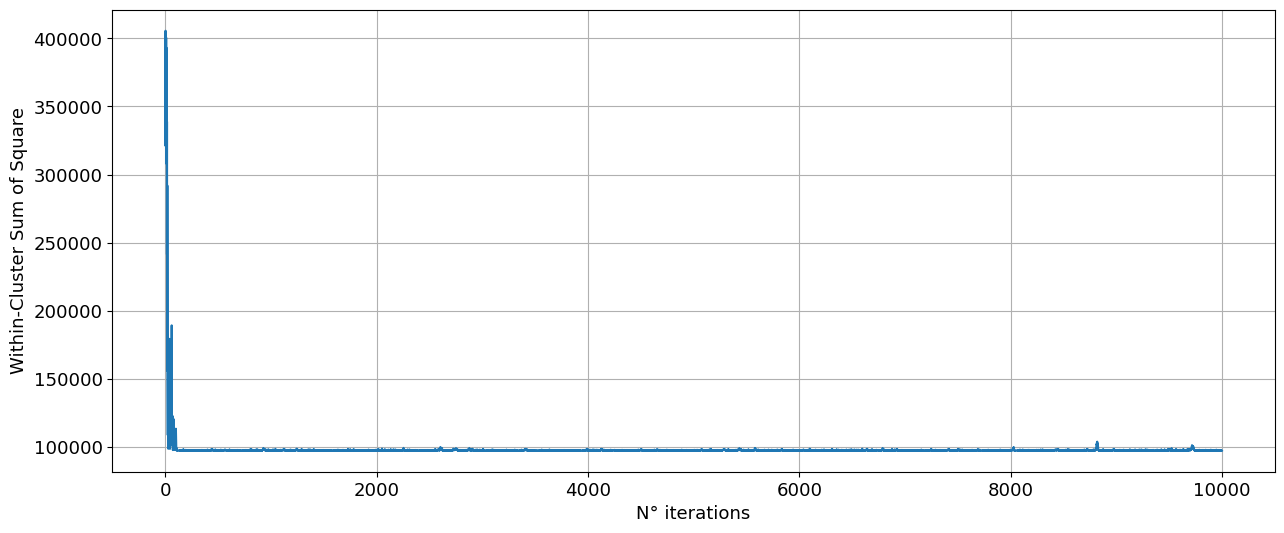

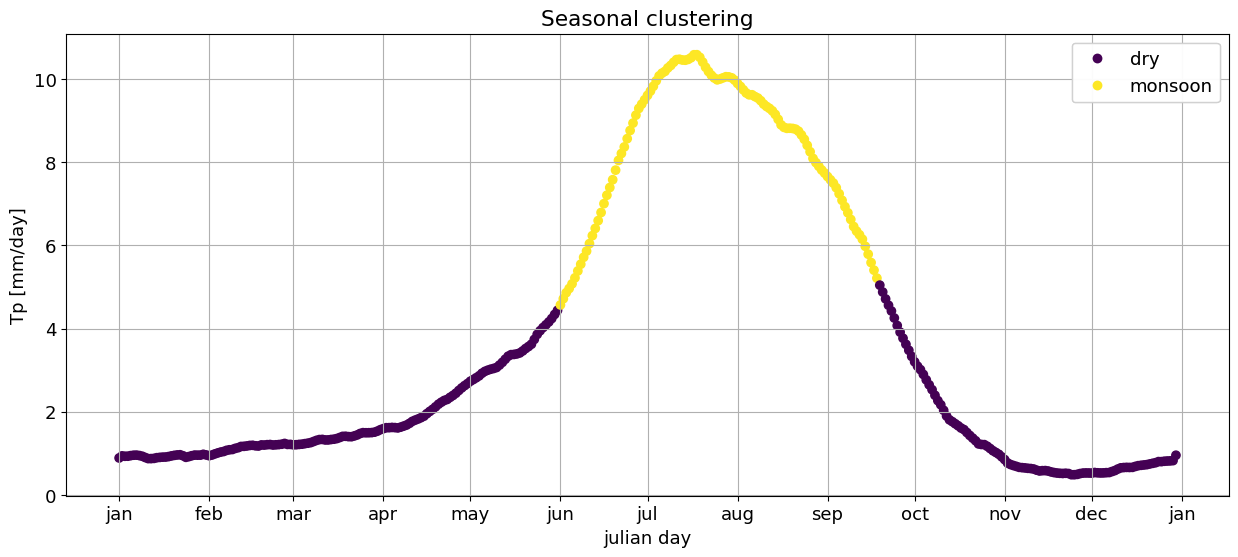

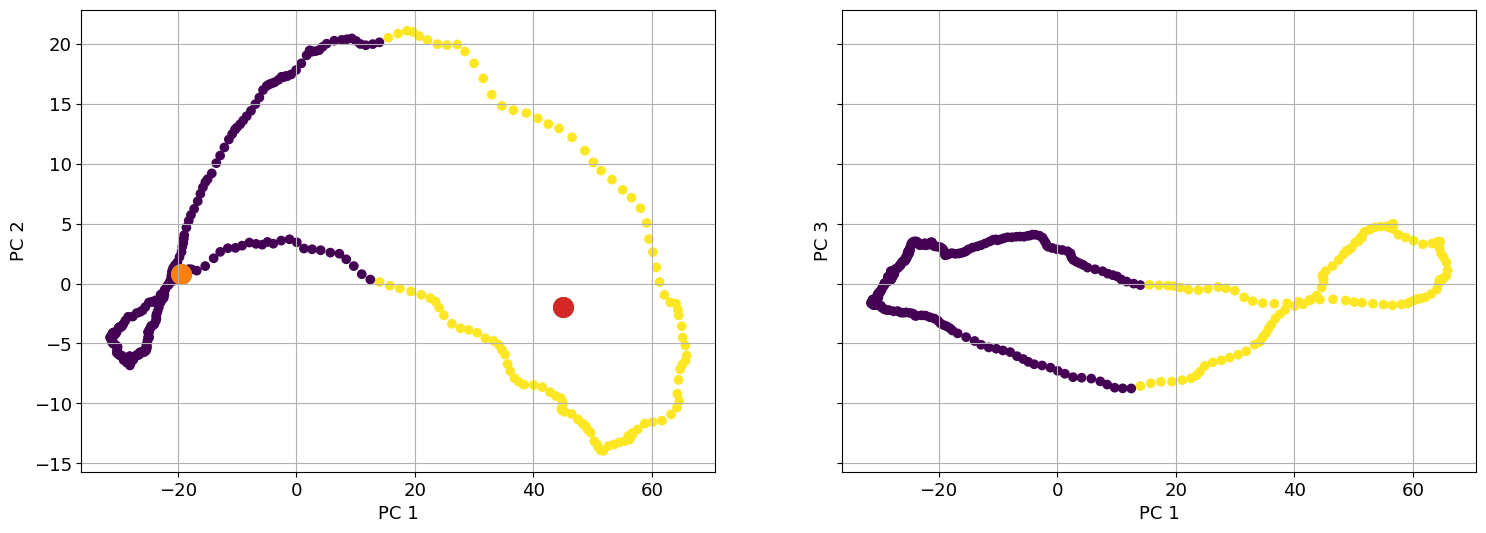

In [5]:
# Creating base for seasonal division
seasons_names = ['dry','monsoon']

to_eof = []
for i in fields:
    supp = getattr(data_to_train_doy,i)
    supp = (supp-supp.mean())/supp.std()
    to_eof.append(supp.to_numpy())

solver = MultivariateEof(to_eof)
pc = solver.pcs(npcs = n_eof_comp)

len_consistancy_check = True
min_len = 10
learning_rate = 50
scheduling_factor = 1.1
l_r_scheduler = True
n_iter = 10000
n_seas = 2

model = Radially_Constrained_Cluster(pc, n_seas, n_iter, 
                                learning_rate, l_r_scheduler, scheduling_factor, 
                                len_consistancy_check, min_len)

model.fit()
prediction = model.get_prediction()


plt.figure(figsize = (15,6))
plt.plot(model.error_story)
plt.grid()
plt.xlabel('N° iterations')
plt.ylabel('Within-Cluster Sum of Square')

cc = model.get_centroids()
print(f'Final error: {model.get_final_error()}')
print(f'Breakpoints: {model.breakpoints}')

fig, ax = plt.subplots(figsize = (15,6))
scatter = ax.scatter(range(np.size(pc, axis=0)), data_to_train_doy.tp.mean(['lat','lon']), c = prediction)
legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=seasons_names)
ax.set_title('Seasonal clustering')
ax.add_artist(legend1)
ax.grid()
ax.set_xlabel('julian day')
ax.set_ylabel('Tp [mm/day]')
ax.set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])


fig, axs = plt.subplots(1,2, figsize = (18,6), sharey = True, sharex=True)
axs[0].scatter(pc[:,0],pc[:,1], c = prediction )
for i in range(n_seas):
    axs[0].scatter(cc[i][0],cc[i][1], s = 200)
    axs[0].scatter(cc[i][0],cc[i][1], s = 200)
axs[0].grid()
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')

axs[1].scatter(pc[:,0],pc[:,2], c = prediction)
axs[1].grid()
axs[1].set_xlabel('PC 1')
axs[1].set_ylabel('PC 3')

In [6]:
to_eof = []
for i in fields:
    supp = getattr(data_to_train,i)
    supp = (supp-supp.mean())/supp.std()
    to_eof.append(supp.to_numpy())


pc_train = solver.projectField(to_eof)
pc_train = pc_train[:,0:n_eof_comp]

y_train = np.squeeze(np.array([prediction]*21).reshape((365*21,1)))

In [7]:
np.shape(pc_train)

(7665, 3)

In [8]:
input = layers.Input(shape=(n_eof_comp))

# Encoder
x = layers.Dense(4, activation='relu')(input)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(n_seas, activation='softmax')(x)


# Autoencoder
lstm_net = Model(input, x)
lstm_net.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics='accuracy')
lstm_net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 4)                 16        
                                                                 
 dense_1 (Dense)             (None, 8)                 40        
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


2022-10-13 19:09:59.872734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/Compiler/11.0/084/lib/intel64:/opt/intel/Compiler/11.0/084/mkl/lib/em64t
2022-10-13 19:09:59.872787: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-13 19:09:59.872823: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wilma): /proc/driver/nvidia/version does not exist
2022-10-13 19:09:59.873564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
54/54 [==============================] - 1s 8ms/step - loss: 1.4844 - accuracy: 0.6970 - val_loss: 0.4237 - val_accuracy: 0.7288
Epoch 2/100
54/54 [==============================] - 0s 3ms/step - loss: 0.4216 - accuracy: 0.8985 - val_loss: 0.1089 - val_accuracy: 0.9596
Epoch 3/100
54/54 [==============================] - 0s 3ms/step - loss: 0.1658 - accuracy: 0.9346 - val_loss: 0.0938 - val_accuracy: 0.9544
Epoch 4/100
54/54 [==============================] - 0s 3ms/step - loss: 0.1220 - accuracy: 0.9438 - val_loss: 0.1052 - val_accuracy: 0.9439
Epoch 5/100
54/54 [==============================] - 0s 3ms/step - loss: 0.1170 - accuracy: 0.9419 - val_loss: 0.1025 - val_accuracy: 0.9465
Epoch 6/100
54/54 [==============================] - 0s 3ms/step - loss: 0.1141 - accuracy: 0.9430 - val_loss: 0.0993 - val_accuracy: 0.9570
Epoch 7/100
54/54 [==============================] - 0s 3ms/step - loss: 0.1120 - accuracy: 0.9455 - val_loss: 0.1046 - val_accuracy: 0.9557
Epoch 8/100
5

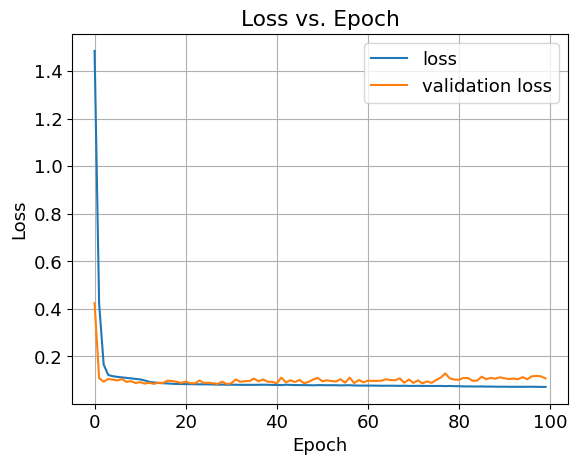

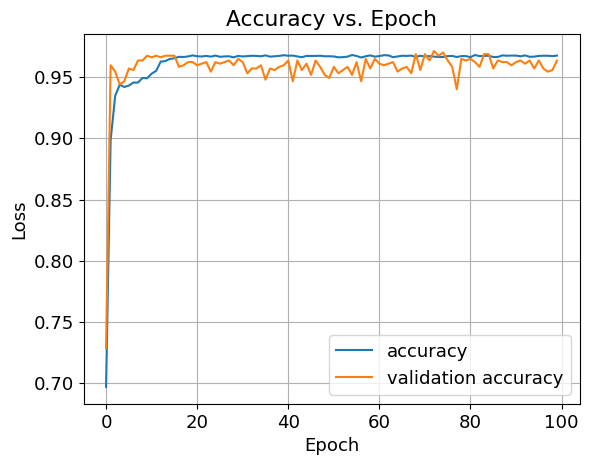

In [9]:
model_history = lstm_net.fit(
    x=pc_train,
    y=y_train,
    epochs=100,
    batch_size=128,
#    validation_data = pc_vale,
    validation_split = 0.1,
    shuffle=True
)

plt.figure()
plt.plot(model_history.history["loss"], label='loss')
plt.plot(model_history.history["val_loss"], label='validation loss')
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)


plt.figure()
plt.plot(model_history.history["accuracy"], label='accuracy')
plt.plot(model_history.history["val_accuracy"], label='validation accuracy')
plt.title("Accuracy vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

100%|██████████| 4/4 [00:16<00:00,  4.16s/it]


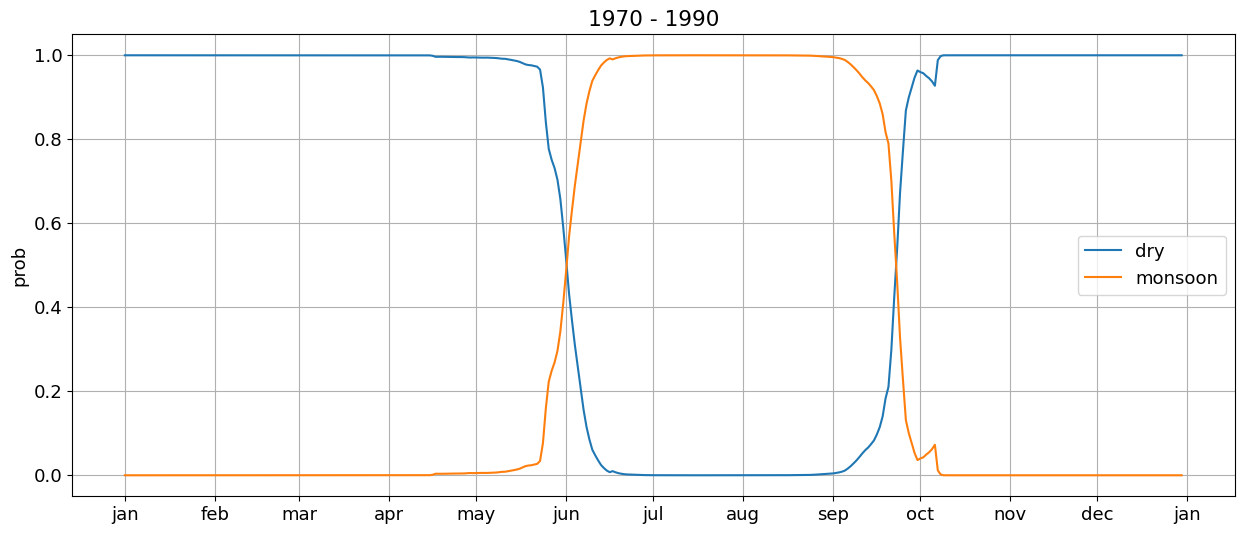

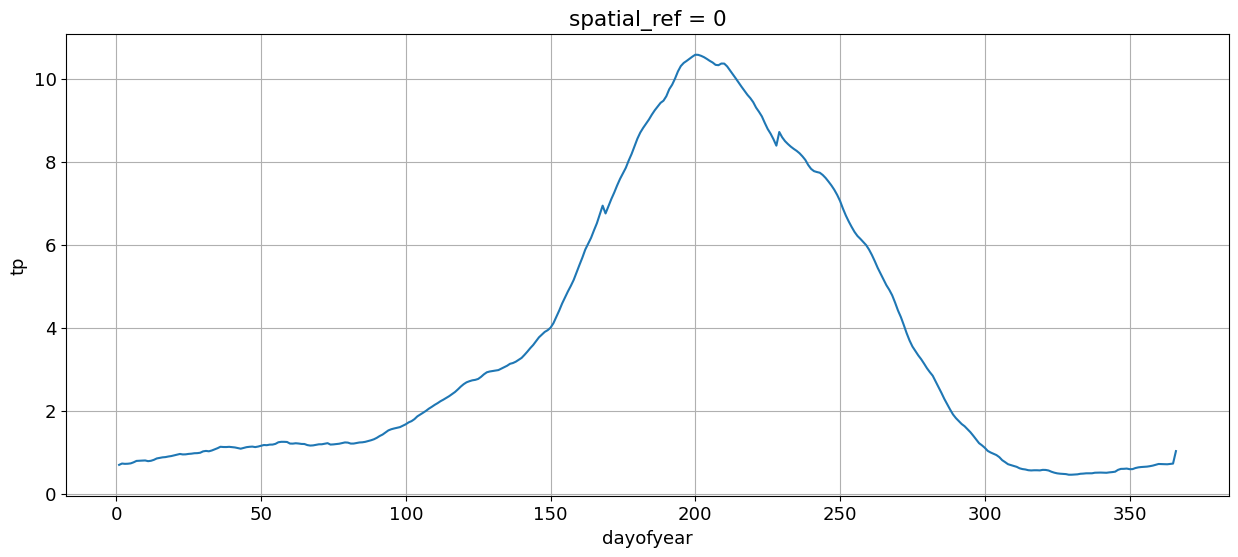

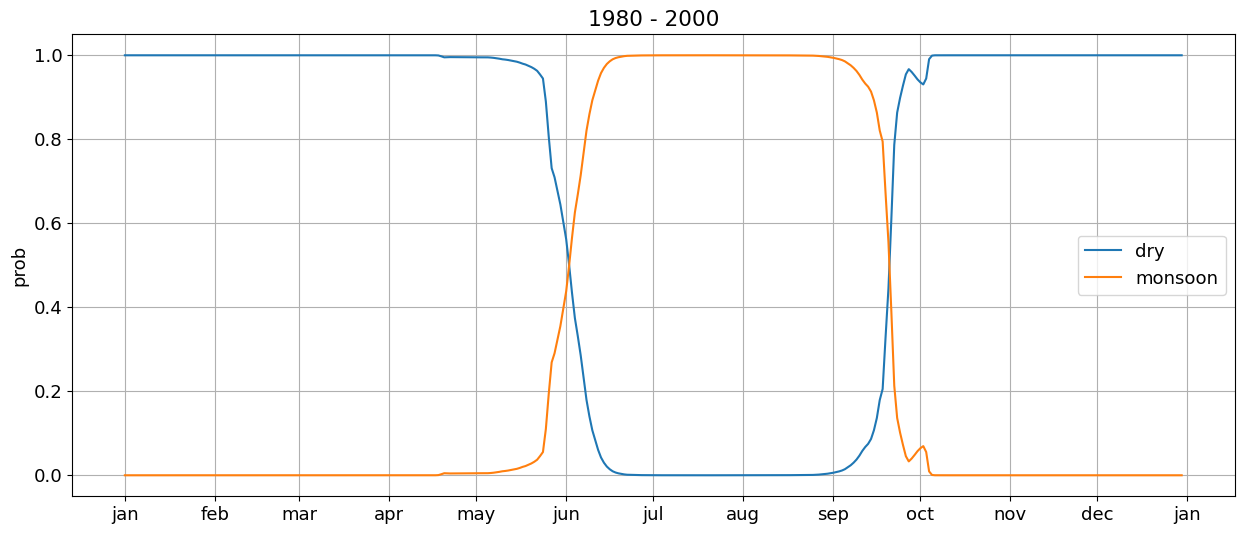

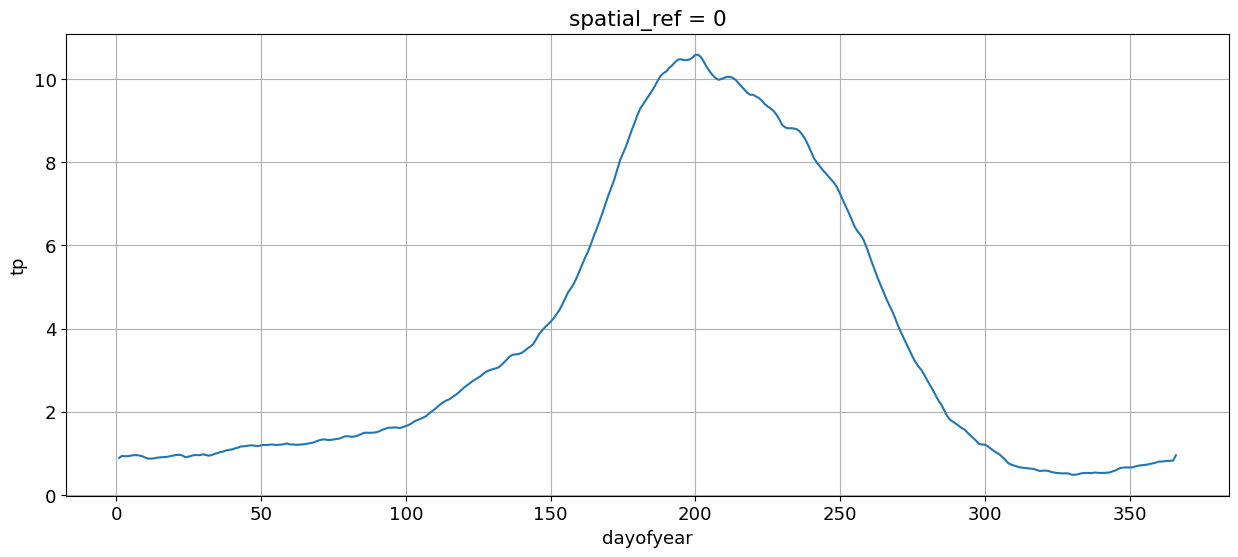

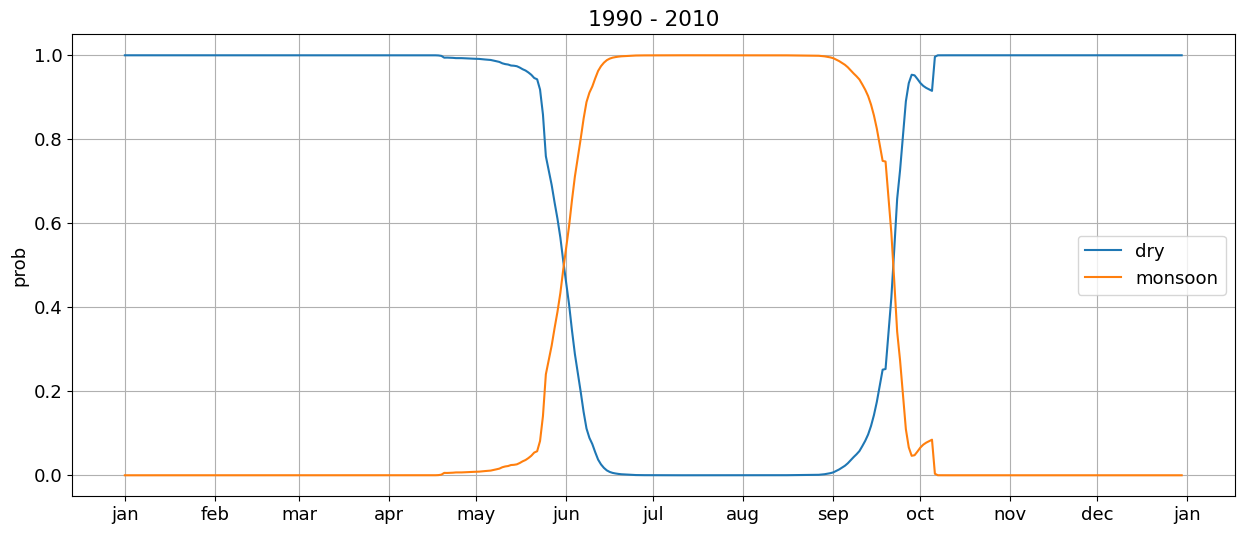

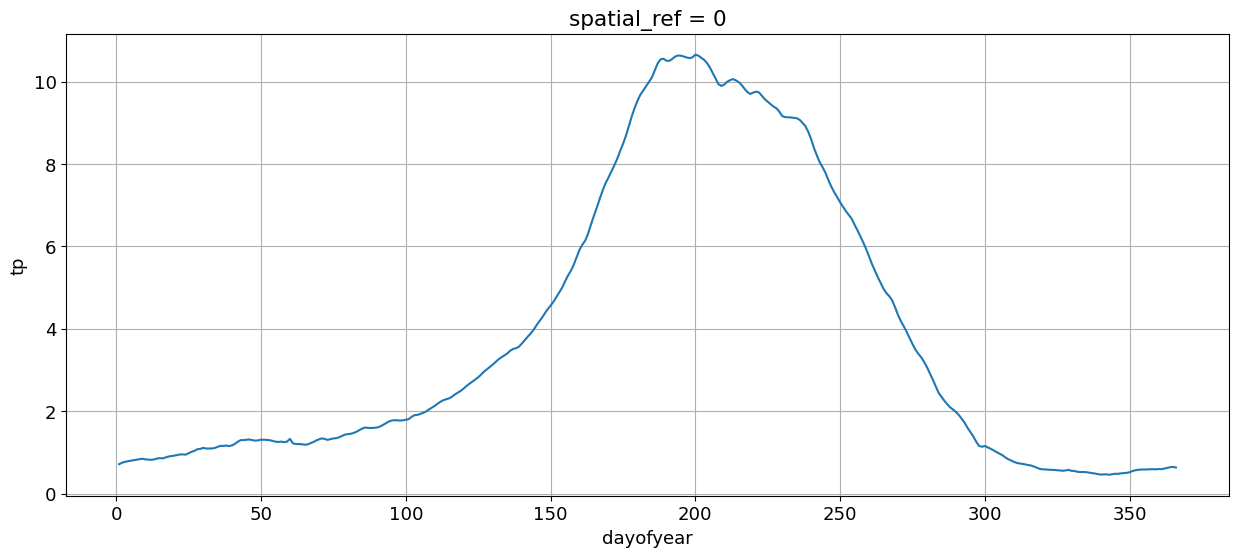

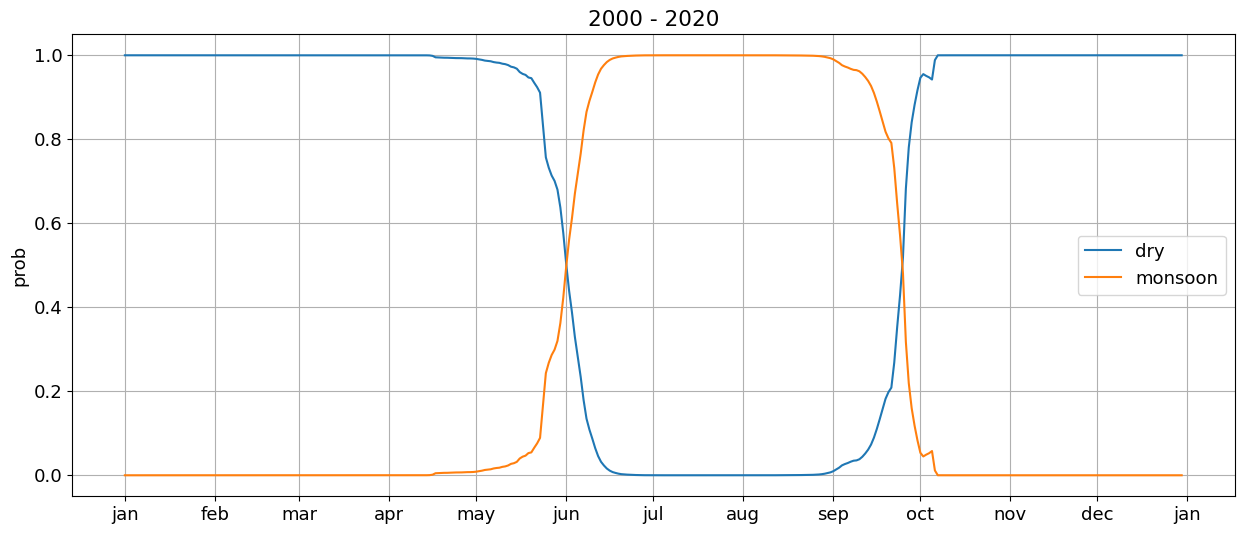

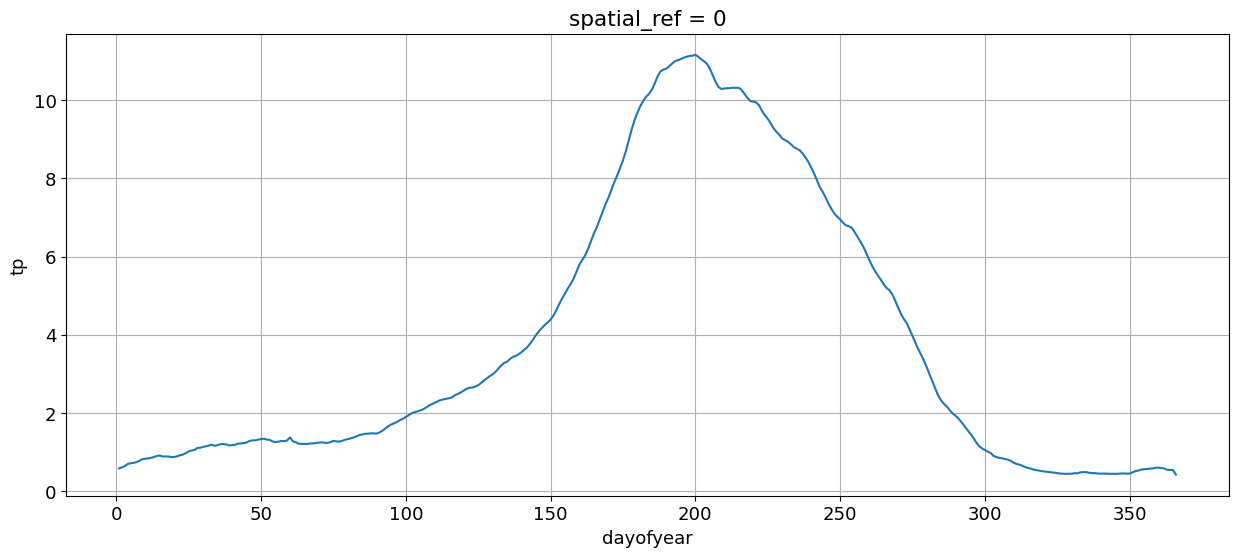

In [10]:
p = []
peri = []
s_index = []

for i in tqdm(np.arange(0,40,10)):

    plt.figure(figsize=(15,6))
    sleep(3)
    data_to_test = data.sel(time=slice(str(1970+i),str(1990+i)))
    data_to_test_doy = data_to_test.groupby('time.dayofyear').mean()

    peri.append([data_to_test['time.year'][0].to_numpy() , data_to_test['time.year'][-1].to_numpy()])

    to_eof = []
    for i in fields:
        supp = getattr(data_to_test_doy,i)
        supp = (supp-supp.mean())/supp.std()
        to_eof.append(supp.to_numpy())


    pc_test = solver.projectField(to_eof)
    pc_test = pc_test[:,0:n_eof_comp]
    pc_test = pc_test[0:365]
    #pc_test = (pc_test)/pc_test.max(axis=0)
    pred_season = lstm_net.predict(pc_test, verbose = 0)
    p.append(pred_season)

    for i in range(n_seas):

        plt.plot(range(0,len(pred_season)),pred_season[:,i], label=f'{seasons_names[i]}')
    
    plt.xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])
    plt.grid()
    plt.legend()
    plt.ylabel('prob')
    plt.title(f"{data_to_test['time.year'][0].to_numpy()} - {data_to_test['time.year'][-1].to_numpy()}")
    
    plt.figure(figsize=(15,6))
    data_to_test_doy.tp.mean(['lat','lon']).plot()
    plt.grid()

    s_index.append(pred_season.argmax(-1))

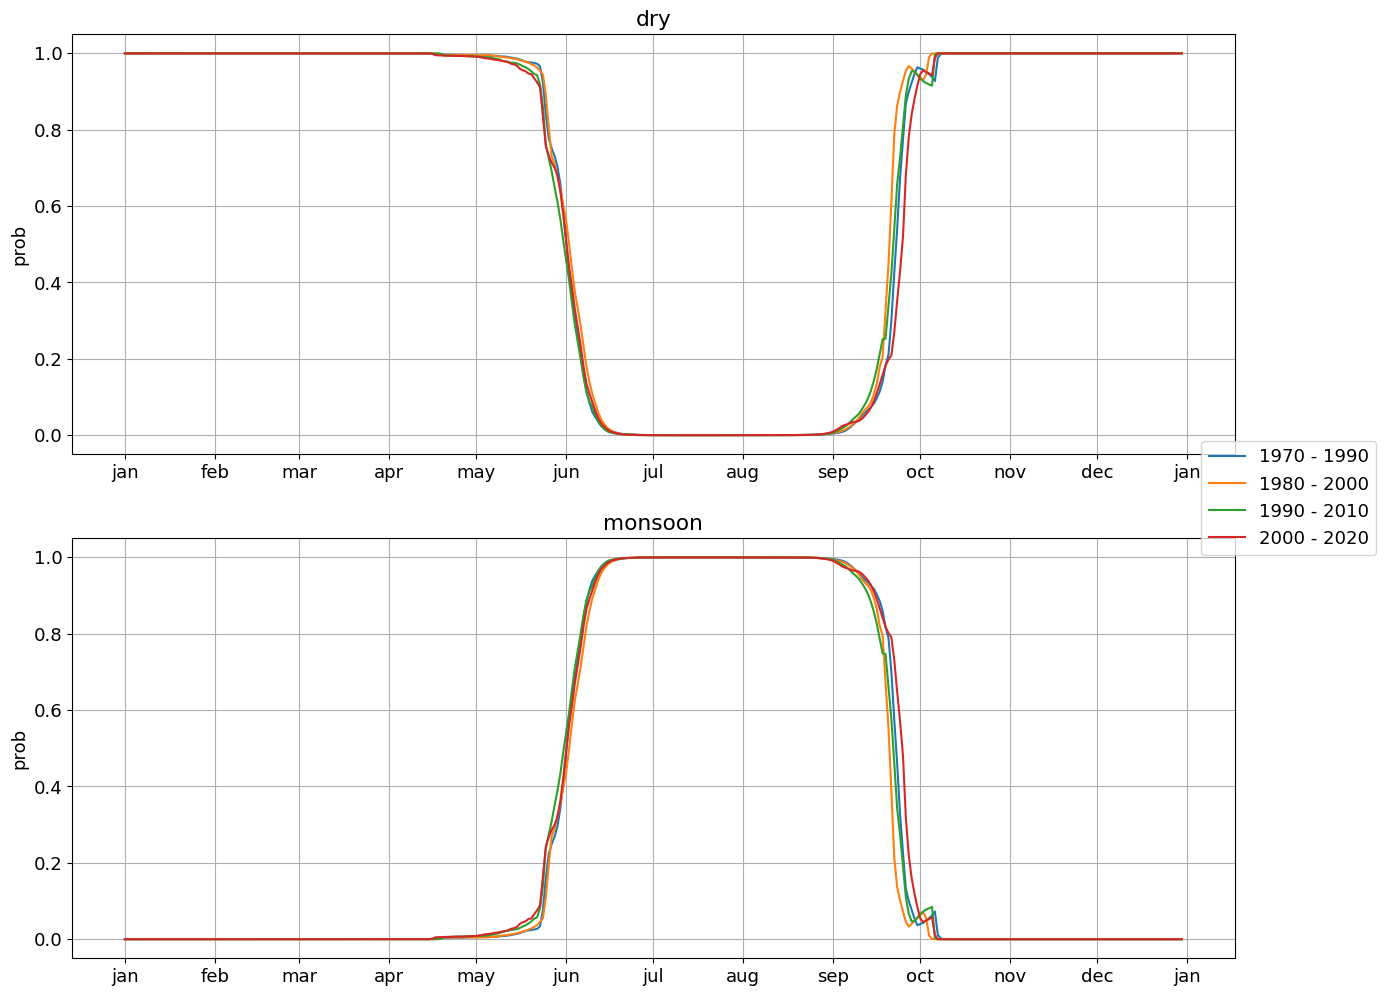

In [11]:
fig, ax = plt.subplots(2,1, figsize=(15,12))

for j in range(len(peri)):

    ax[0].plot(range(0,len(pred_season)),p[j][:,0])
    ax[0].set_title(f'{seasons_names[0]}')
    ax[1].plot(range(0,len(pred_season)),p[j][:,1], label = f'{peri[j][0]} - {peri[j][1]}')
    ax[1].set_title(f'{seasons_names[1]}')


for i in ax:
    i.set_ylabel('prob')
    i.grid()
    i.set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])



fig.legend(loc = 'center right')

In [12]:
p = []
peri = []
s_index = []
s_len = []
s_mean = []

for i in tqdm(np.arange(0,50,1)):

    sleep(3)
    data_to_test = data.sel(time=slice(str(1950+i),str(1970+i)))
    data_to_test_doy = data_to_test.groupby('time.dayofyear').mean()

    l_t = data_to_test_doy.mean(['lat','lon']).tp.to_numpy()
    l_t = l_t[0:365]

    peri.append([data_to_test['time.year'][0].to_numpy() , data_to_test['time.year'][-1].to_numpy()])

    to_eof = []
    for i in fields:
        supp = getattr(data_to_test_doy,i)
        supp = (supp-supp.mean())/supp.std()
        to_eof.append(supp.to_numpy())


    pc_test = solver.projectField(to_eof)
    pc_test = pc_test[:,0:n_eof_comp]
    pc_test = pc_test[0:365]
    pred_season = lstm_net.predict(pc_test, verbose=0)
    p.append(pred_season)

    predi = pred_season.argmax(-1)
    
    s_index.append(predi)

    len_seas = np.empty((n_seas,1))
    mean_seas = np.empty((n_seas,1))

    for k in range(n_seas):
        len_seas[k] = np.count_nonzero(predi==k)
        mean_seas[k] = np.mean(l_t[predi==k])

    s_len.append(len_seas)
    s_mean.append(mean_seas)

100%|██████████| 50/50 [03:15<00:00,  3.91s/it]


Text(0.5, 1.0, 'Season mean')

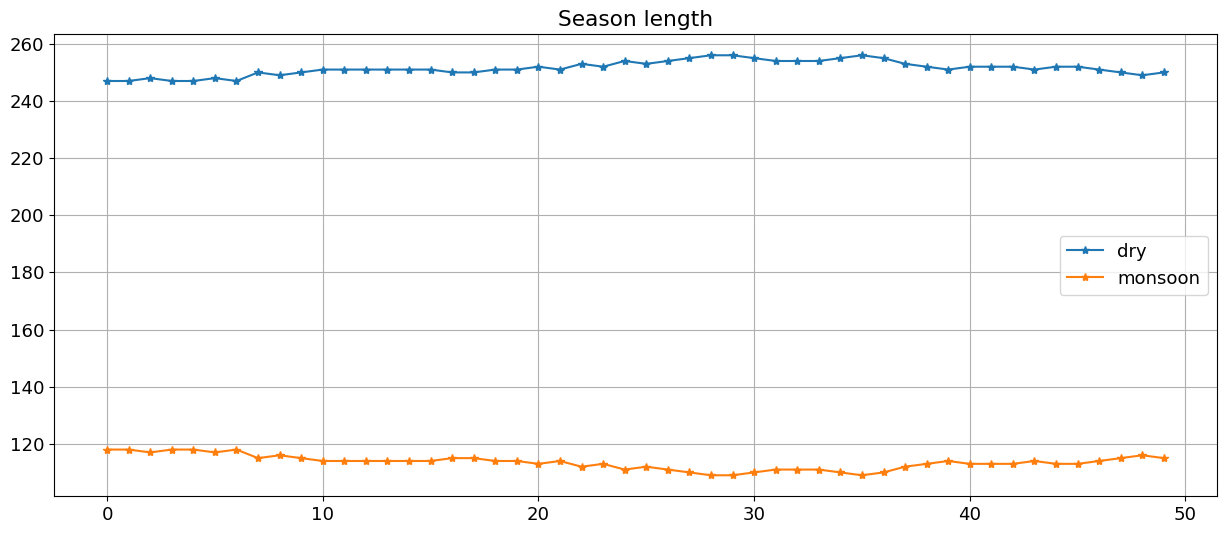

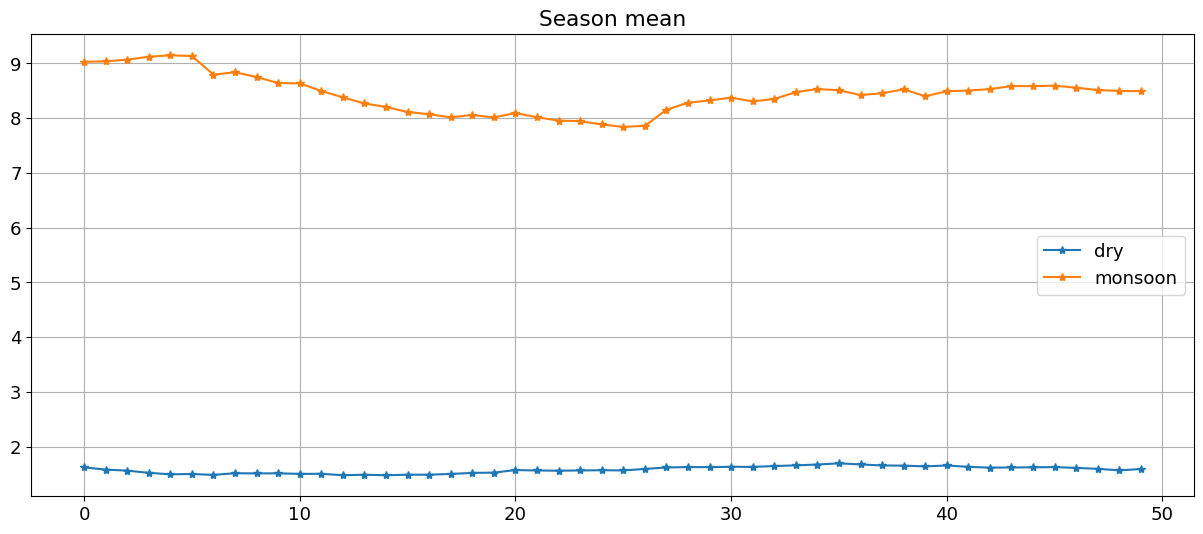

In [13]:
s_len = np.array(s_len)
s_mean = np.array(s_mean)

plt.figure(figsize=(15,6))
for j in range(n_seas):

        plt.plot(s_len[:,j], '-*', label = seasons_names[j])

plt.legend()
plt.grid()
plt.title('Season length')


plt.figure(figsize=(15,6))
for j in range(n_seas):

        plt.plot(s_mean[:,j], '-*', label = seasons_names[j])

plt.legend()
plt.grid()
plt.title('Season mean')


/tmp/ipykernel_977761/2417149041.py:8: UserWarning: The following kwargs were not used by contour: 'vamx'
  cs = plt.contourf(range(365), ps[:,0], pr[:,:,i], origin='lower', cmap='Reds',vmin=0,vamx=1.1)


<Figure size 2000x500 with 0 Axes>

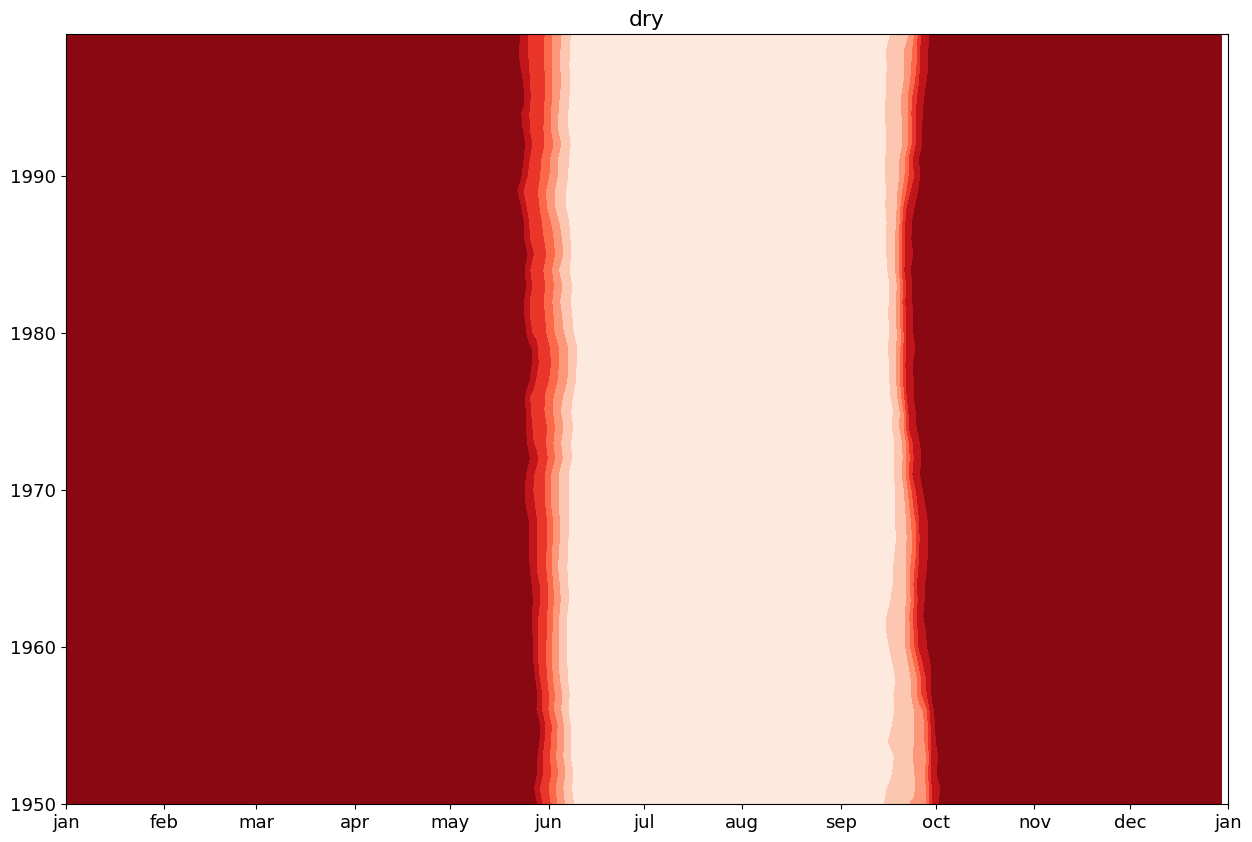

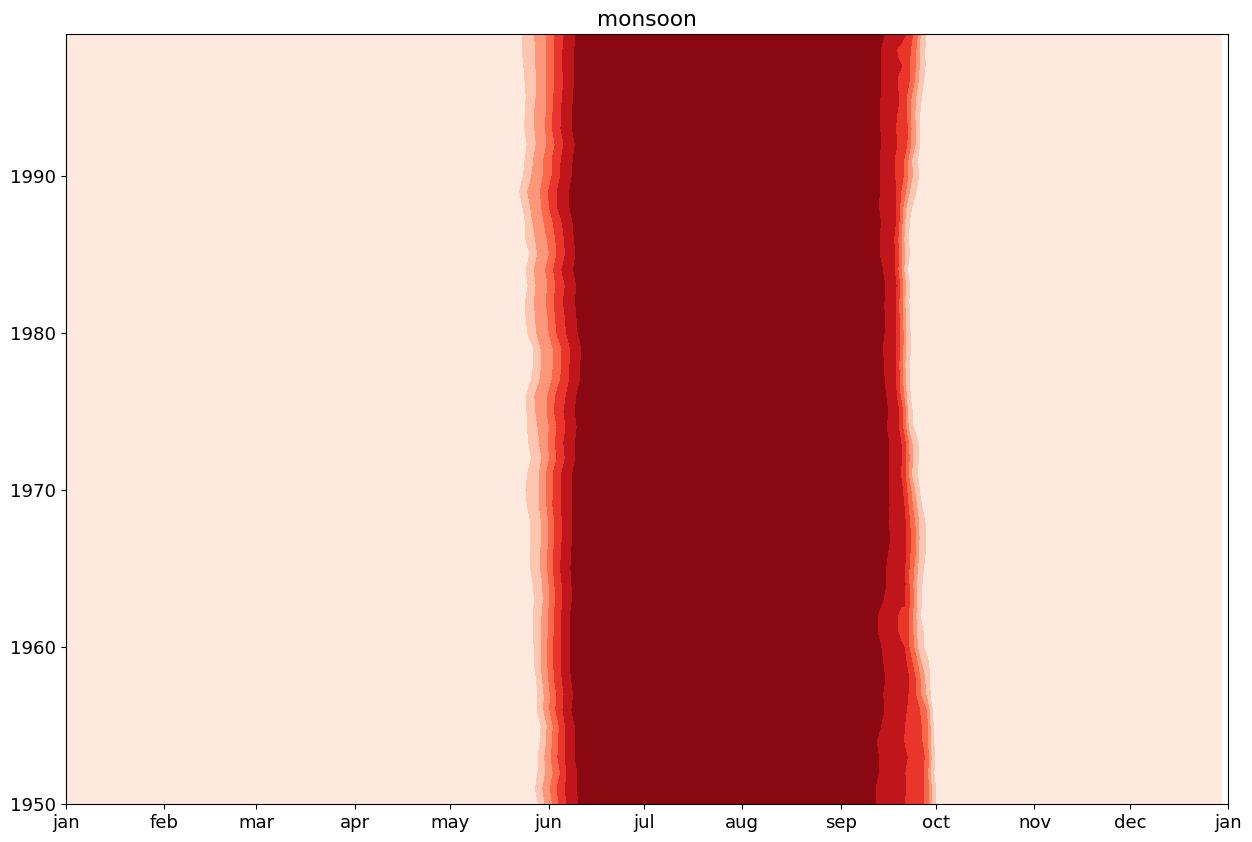

In [14]:
pr = np.squeeze(np.array(p))
plt.figure(figsize=(20,5))
ps = np.squeeze(np.array(peri))


for i in range(n_seas):
    plt.figure(figsize=(15,10))
    cs = plt.contourf(range(365), ps[:,0], pr[:,:,i], origin='lower', cmap='Reds',vmin=0,vamx=1.1)
    plt.title(seasons_names[i])
    plt.xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])